In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
torch.manual_seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
!unzip Data.zip -d /content/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Data/training_set/cats/cat.3706.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3707.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3708.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3709.jpg  
  inflating: /content/data/Data/training_set/cats/cat.371.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3710.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3711.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3712.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3713.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3714.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3715.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3716.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3717.jpg  
  inflating: /content/data/Data/training_set/cats/cat.3718.jpg  
  inflating: /content/data/Data/training

In [37]:
# Image transformations (Resize + Augmentation + Normalization)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),           # সব ইমেজকে 128x128 করবো
    transforms.RandomHorizontalFlip(p=0.5),  # data augmentation (flip)
    transforms.RandomRotation(20),           # data augmentation (rotate)
    transforms.ToTensor(),                   # টেনসর বানানো
    transforms.Normalize((0.5, 0.5, 0.5),    # RGB channels normalization
                         (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

In [38]:
 #Load training dataset
train_data = datasets.ImageFolder(root="/content/data/Data/training_set", transform=train_transform)

In [39]:
# Load test dataset
test_data = datasets.ImageFolder(root="/content/data/Data/test_set", transform=test_transform)

In [40]:
# DataLoader (batch-wise data নেয়ার জন্য)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory = True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, pin_memory = True)

In [41]:
# Function: Tensor -> Numpy Image (unnormalize করে)
def imshow(img, title=None):
    img = img / 2 + 0.5     # unnormalize (-1,1) → (0,1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # C,H,W → H,W,C
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

In [42]:
# একটা batch বের করি
dataiter = iter(train_loader)
images, labels = next(dataiter)

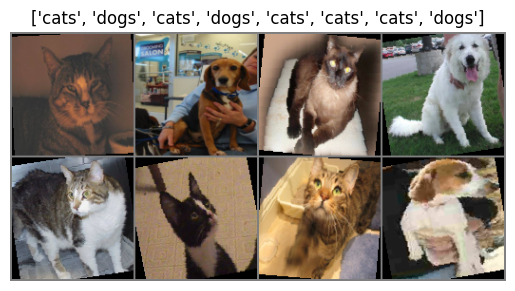

In [43]:
# ইমেজগুলো grid আকারে দেখাই
from torchvision.utils import make_grid

imshow(make_grid(images[:8], nrow=4),
       title=[train_data.classes[l] for l in labels[:8]])

In [44]:
class cat_dog_CNN(nn.Module):

  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256*8*8, 512),
        nn.ReLU(),
        nn.Dropout(p=0.6),

        nn.Linear(512,128),
        nn.ReLU(),
        nn.Dropout(p=0.6),

        nn.Linear(128,2),
    )


  def forward(self,x):
    x = self.features(x)
    x = self.classifier(x)

    return x

In [45]:
learning_rate = 0.001
epochs = 25

In [46]:
model = cat_dog_CNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [47]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.8159727553922341
Epoch: 2 , Loss: 0.6616823924965117
Epoch: 3 , Loss: 0.6351513222631705
Epoch: 4 , Loss: 0.6109085850031727
Epoch: 5 , Loss: 0.5915251331500323
Epoch: 6 , Loss: 0.5717575573826216
Epoch: 7 , Loss: 0.5511394172788141
Epoch: 8 , Loss: 0.5231397359732137
Epoch: 9 , Loss: 0.48522000056338976
Epoch: 10 , Loss: 0.4581650936033621
Epoch: 11 , Loss: 0.435253610352121
Epoch: 12 , Loss: 0.4005338465312563
Epoch: 13 , Loss: 0.37440589141560743
Epoch: 14 , Loss: 0.3368886832993819
Epoch: 15 , Loss: 0.3268632225365753
Epoch: 16 , Loss: 0.30867331768886974
Epoch: 17 , Loss: 0.28148577484001674
Epoch: 18 , Loss: 0.2798750562986648
Epoch: 19 , Loss: 0.263314899769556
Epoch: 20 , Loss: 0.25755891707017126
Epoch: 21 , Loss: 0.23558236024828547
Epoch: 22 , Loss: 0.262595587933206
Epoch: 23 , Loss: 0.23600579286179693
Epoch: 24 , Loss: 0.2097465792945419
Epoch: 25 , Loss: 0.21019995301605696


In [48]:
model.eval()

cat_dog_CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [49]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8971824023727137


In [50]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9247970018738289


In [51]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

In [52]:
def predict_image(model, image_path, classes, device):
    transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

    # Image load
    image = Image.open(img_path).convert('RGB')
    img_t = transform(image).unsqueeze(0)  # batch dimension add
    img_t = img_t.to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_t)
        _, predicted = torch.max(output, 1)

    # Prediction result
    label = classes[predicted.item()]

    # Show image with prediction
    plt.imshow(image)
    plt.title(f"Predicted: {label}")
    plt.axis("off")
    plt.show()

    return label


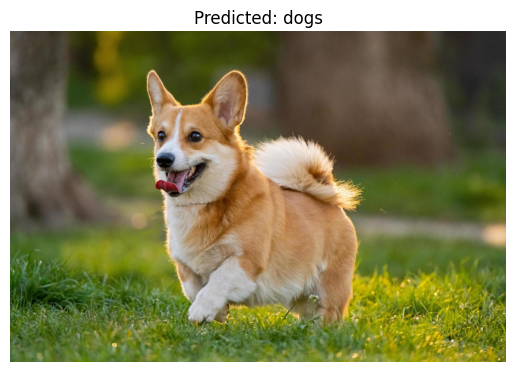

Prediction: dogs


In [ ]:
classes = ['cats', 'dogs']
img_path = "/content/dog.jpg"   

result = predict_image(model, img_path, classes, device)
print("Prediction:", result)
